In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Loading Dataset

In [2]:
train_file_path = "/content/train.csv"
submission_file_path = "/content/test.csv"
train_data = pd.read_csv(train_file_path)
submission_data = pd.read_csv(submission_file_path)

Data Preprocessing

In [3]:
y_train_full = train_data["label"]
X_train_full = train_data.drop("label", axis=1)

X_submission = submission_data

In [4]:
# normalizing
X_train_full = X_train_full / 225
X_submission = X_submission / 225

# convert the pd DataFrame into np Array
X_train_full = X_train_full.values.reshape(-1,28,28,1)
X_submission = X_submission.values.reshape(-1,28,28,1)

# one-hot encoding
y_train_full = to_categorical(y_train_full, num_classes=10)

In [5]:
print(X_train_full.shape)
print(y_train_full.shape)
print(type(X_train_full))

(42000, 28, 28, 1)
(42000, 10)
<class 'numpy.ndarray'>


In [6]:
# split the full training data set in to Training, Validation and Test set
train_size = 0.8
val_size = 0.1
random_seed = 100

X_train, X_val_n_test, y_train, y_val_n_test = train_test_split(X_train_full, y_train_full, train_size=train_size, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_n_test, y_val_n_test, train_size=val_size/(1-train_size), random_state=random_seed)

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33600, 28, 28, 1)
(4200, 28, 28, 1)
(4200, 28, 28, 1)


Data Augmentation

In [8]:
data_gen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

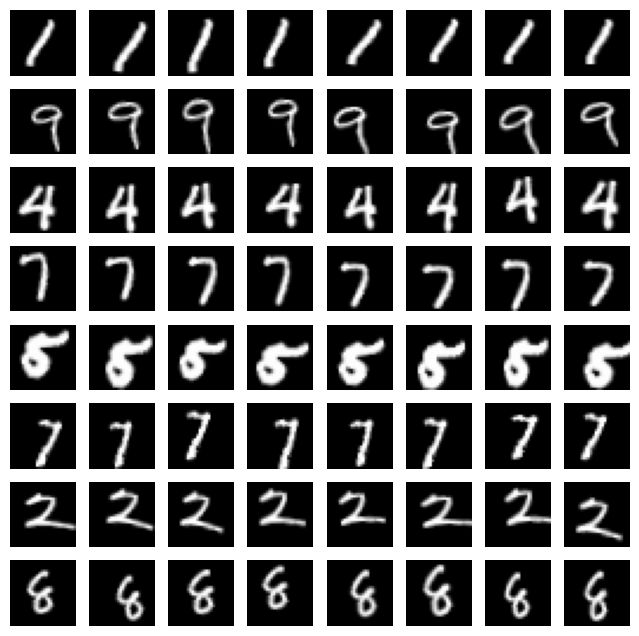

In [9]:
# Augmented Images preview
a = 8 # a: number of sample image we take for augmentation process
b = 8 # b: number of augmentation we implement on a single sample

fig, axes = plt.subplots(a, b, figsize=(b,a))

random_indices = random.sample(range(X_train.shape[0]), a)

for i in range(a):
    for j in range(b):
        X_sample = X_train[random_indices[i]].reshape((1,28,28,1))
        y_sample = y_train[random_indices[i]].reshape((1,10))

        X_aug, y_aug = next(data_gen.flow(X_sample, y_sample, batch_size=1))

        ax = axes[i][j]
        ax.imshow(X_aug.reshape((28,28)), cmap='gray')
        ax.set_axis_off()

Data Visualisation

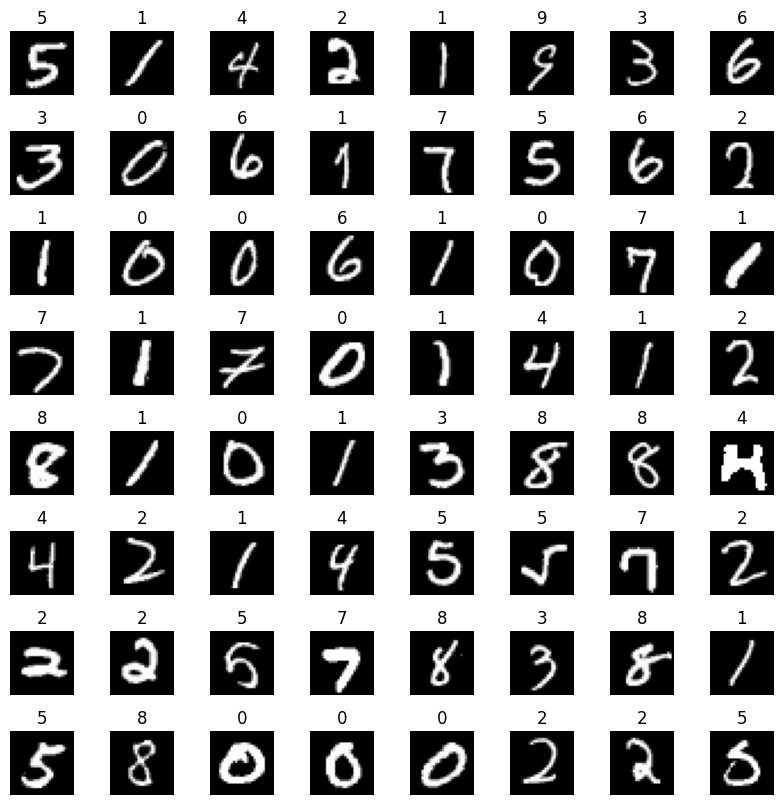

In [10]:
fig, axes = plt.subplots(8, 8, figsize=(8,8))
fig.tight_layout(pad=0.01)

m = X_train.shape[0]

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)

    reshaped_random_X = X_train[random_index].reshape((28,28))

    ax.imshow(reshaped_random_X, cmap='gray')
    ax.set_title(int(np.argmax(y_train[random_index])))
    ax.set_axis_off()

Define Model and hyperparameters

In [11]:
# Hyperparameters
batch_size = 64
epochs = 500
input_shape = X_train.shape[1:]
print(input_shape)

(28, 28, 1)


In [12]:
model_1 = Sequential([
    Conv2D(filters=32, kernel_size=3, input_shape=input_shape, padding='same'),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),

    Conv2D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),

    Conv2D(filters=128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),

    Flatten(),

    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=10, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=5, input_shape=input_shape, padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Dropout(0.25),

    Flatten(),

    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=10, activation='softmax')

])

In [14]:
model_3 = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(filters=128, kernel_size=4, activation='relu'),
    BatchNormalization(),

    Flatten(),

    Dropout(0.4),
    Dense(units=10, activation='softmax')

])

In [15]:
model = model_2

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,530 (3.39 MB)

 Trainable params: 887,530 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

Fitting the data

In [18]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [19]:
history = model.fit(
    data_gen.flow(X_train, y_train),
    # X_train, y_train,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 89s 165ms/step - accuracy: 0.6663 - loss: 0.9805 - val_accuracy: 0.9712 - val_loss: 0.0931
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 91s 173ms/step - accuracy: 0.9441 - loss: 0.1842 - val_accuracy: 0.9814 - val_loss: 0.0582
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 112s 167ms/step - accuracy: 0.9588 - loss: 0.1323 - val_accuracy: 0.9848 - val_loss: 0.0475
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 89s 169ms/step - accuracy: 0.9632 - loss: 0.1182 - val_accuracy: 0.9845 - val_loss: 0.0432
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 83s 158ms/step - accuracy: 0.9699 - loss: 0.0946 - val_accuracy: 0.9862 - val_loss: 0.0478
Epoch 6/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 163ms/step - accuracy: 0.9690 - loss: 0.1021 - val_accuracy: 0.9850 - val_loss: 0.0503
Epoch 7/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - accuracy: 0.9754 - loss: 0.0846 - val_accuracy: 0.9902 - val_loss: 0.0325
Epoch 8/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 83s 159ms/step - accuracy: 0.9757 - loss: 0.08

Evaluation of model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Text(0.5, 1.0, 'True: 1    |    Pred: 1')

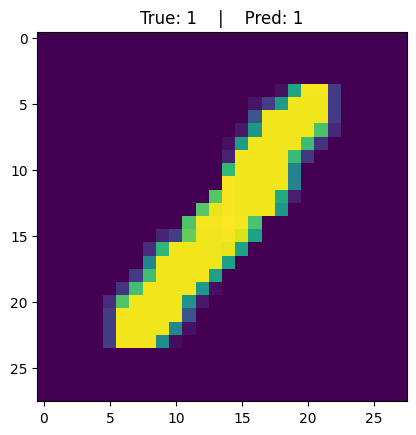

In [20]:
index = 10012

y_pred = model.predict(X_train[index].reshape((1,28,28,1)))
y_pred = int(np.argmax(y_pred))
y_true = int(np.argmax(y_train[index]))
plt.imshow(X_train[index].reshape((28,28)))
plt.title(f"True: {y_true}    |    Pred: {y_pred}")

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9908 - loss: 0.0314
Test loss:  0.031865932047367096
Test accuracy:  0.9904761910438538


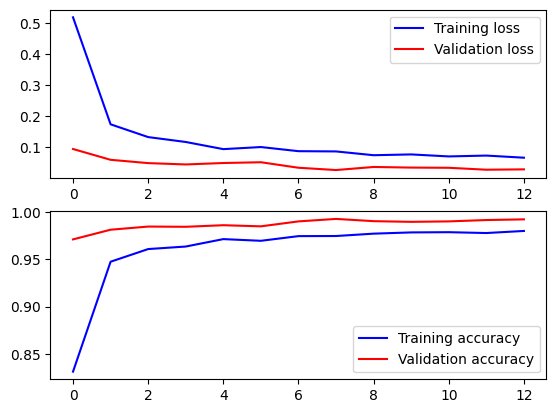

In [22]:
fig, axes = plt.subplots(2, 1)

axes[0].plot(history.history["loss"], color="b", label="Training loss")
axes[0].plot(history.history["val_loss"], color="r", label="Validation loss")
legend = axes[0].legend(loc="best")

axes[1].plot(history.history["accuracy"], color="b", label="Training accuracy")
axes[1].plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
legend = axes[1].legend(loc="best")

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


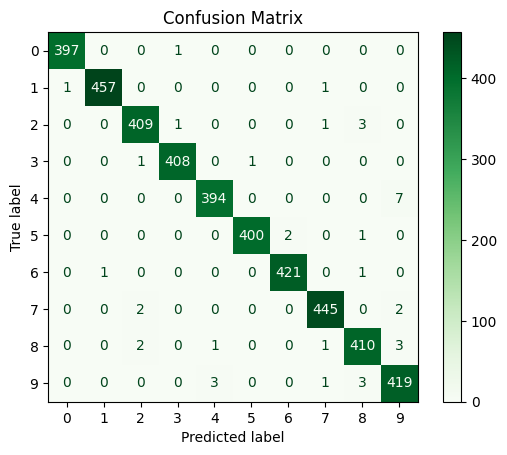

In [25]:
y_test_preds = model.predict(X_test)
y_test_preds = y_test_preds.argmax(axis=1)
y_test_label = y_test.argmax(axis=1)#Confusion Matrix
cm = confusion_matrix(y_test_label, y_test_preds)

# Display confusion matrix with sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()